# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif

# Reading dataset

In [2]:
df = pd.read_csv('data.csv')

# Missing value

In [4]:
print("مقادیر گمشده در هر ستون:")
print(df.isnull().sum())
for column in df.columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].mean(), inplace=True)

مقادیر گمشده در هر ستون:
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimens

C:\Users\user\AppData\Local\Temp\ipykernel_10452\4011762438.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


# Convert Categorical data to Numerical

In [5]:
# حذف ستون‌های اضافی
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

#  One-Hot Encoding 
df_encoded = pd.get_dummies(df, columns=['diagnosis'], prefix='diagnosis')
df_encoded['diagnosis_M'] = df_encoded['diagnosis_M'].astype(int)
df_encoded['diagnosis_B'] = df_encoded['diagnosis_B'].astype(int)
df_encoded.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  ...  perimeter_worst  area_worst  smoothness_worst  \
0                 0.07871  ...           184.60      2019.0            0.1622   
1                 0.05667  ...           158.80      1956.0            0.1238   
2                 0.05999  ...           152.50      1709.0            0.1444   
3                 0.09744  ...            98.87       567.7            0.2098   
4                 0.05883  ...           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  diagnosis_B  diagnosis_M  
0                  0.11890            0            1  
1                  0.08902            0            1  
2                  0.08758            0            1  
3                  0.17300            0            1  
4                  0.07678            0            1  

[5 rows x 32 columns]

# Find Outliers

# Replacing outliers with the classed median

In [6]:
# تعریف تابع برای جایگزینی پرت‌ها با میانه کلاس‌بندی‌شده
def replace_outliers_with_class_median(df, column, target_column='diagnosis_M'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # محاسبه میانه برای هر کلاس
    median_by_class = df.groupby(target_column)[column].median()
    
    # جایگزینی پرت‌ها با میانه کلاس مربوطه
    for class_label in df[target_column].unique():
        mask = (df[target_column] == class_label) & ((df[column] < lower_bound) | (df[column] > upper_bound))
        df.loc[mask, column] = median_by_class[class_label]
    return df

# اعمال تابع روی تمام ستون‌های عددی (به جز هدف)
numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns:
    if column != 'diagnosis_M':
        df_encoded = replace_outliers_with_class_median(df_encoded, column)

print("\nدیتاست بعد از جایگزینی پرت‌ها با میانه کلاس‌بندی‌شده:")
print(df_encoded.head())


دیتاست بعد از جایگزینی پرت‌ها با میانه کلاس‌بندی‌شده:
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.10220   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.13235         0.15135              0.14710         0.2419   
1           0.07864         0.08690              0.07017         0.1812   
2           0.15990         0.19740              0.12790         0.2069   
3           0.13235         0.24140              0.10520         0.1899   
4           0.13280         0.19800              0.10430         0.1809   

   fractal_dimension_mean  ...  perim

# Train and Test Data

In [7]:
X = df_encoded.drop(['diagnosis_M'], axis=1)
y = df_encoded['diagnosis_M']

# 4. تقسیم اولیه به Train و (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.702, random_state=100)  # حداقل 70% آموزش

# 5. تقسیم دوم به Validation و Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=100)  # 15% از کل برای تست، بقیه برای اعتبارسنجی

# چک دقیق درصدها
total_samples = len(X)
print(f"تعداد کل نمونه‌ها: {total_samples}")
print(f"تعداد نمونه‌های آموزش: {len(X_train)} ({len(X_train)/total_samples*100:.2f}%)")
print(f"تعداد نمونه‌های تست: {len(X_test)} ({len(X_test)/total_samples*100:.2f}%)")
print(f"تعداد نمونه‌های اعتبارسنجی: {len(X_val)} ({len(X_val)/total_samples*100:.2f}%)")

تعداد کل نمونه‌ها: 569
تعداد نمونه‌های آموزش: 399 (70.12%)
تعداد نمونه‌های تست: 85 (14.94%)
تعداد نمونه‌های اعتبارسنجی: 85 (14.94%)


# Normalize

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Choose 25 important features

In [21]:
selector = SelectKBest(score_func=f_classif, k=20)
X_train_scaled_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_scaled_selected = selector.transform(X_val_scaled)
X_test_scaled_selected = selector.transform(X_test_scaled)

# گرفتن نام ویژگی‌های انتخاب‌شده
all_feature_names = X.columns.tolist()
selected_mask = selector.get_support()
feature_names = [all_feature_names[i] for i in range(len(selected_mask)) if selected_mask[i]]
print("\nویژگی‌های انتخاب‌شده:", feature_names)


ویژگی‌های انتخاب‌شده: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


# Model fitting

In [124]:
# تنظیم مدل
model = LogisticRegression(max_iter=1000, C=0.06, penalty='l2',class_weight='balanced', random_state=42)

# فیت مدل
model.fit(X_train_scaled_selected, y_train)

LogisticRegression(C=0.06, class_weight='balanced', max_iter=1000,
                   random_state=42)

# Cross-Validation

# Accuracy on validation data

In [125]:
#  ارزیابی روی دیتای اعتبارسنجی
y_val_pred = model.predict(X_val_scaled_selected)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"دقت روی دیتای اعتبارسنجی: {val_accuracy:.3f}")

دقت روی دیتای اعتبارسنجی: 0.953


# Accuracy on train data

In [126]:
#  ارزیابی روی دیتای آموزشی
y_train_pred = model.predict(X_train_scaled_selected)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"دقت روی دیتای آموزشی: {train_accuracy:.3f}")

دقت روی دیتای آموزشی: 0.970


# Evaluation on test data

In [127]:
#  ارزیابی روی دیتای تست
y_test_pred = model.predict(X_test_scaled_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"دقت روی دیتای تست: {test_accuracy:.3f}")
print("\nگزارش طبقه‌بندی برای دیتای تست:")
print(classification_report(y_test, y_test_pred, target_names=['خوش‌خیم', 'بدخیم']))

دقت روی دیتای تست: 0.965

گزارش طبقه‌بندی برای دیتای تست:
              precision    recall  f1-score   support

     خوش‌خیم       0.94      1.00      0.97        49
       بدخیم       1.00      0.92      0.96        36

    accuracy                           0.96        85
   macro avg       0.97      0.96      0.96        85
weighted avg       0.97      0.96      0.96        85



# Optimal parameters

In [18]:
feature_importance = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Coefficient': model.coef_[0]})
print("\nچند ویژگی مهم بر اساس ضرایب مدل:\n")
print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False).head(15))


چند ویژگی مهم بر اساس ضرایب مدل:

                 Feature  Coefficient
19  concave points_worst     0.367335
13         texture_worst     0.362294
16      smoothness_worst     0.342079
15            area_worst     0.309323
12          radius_worst     0.292611
6    concave points_mean     0.286486
9                area_se     0.285748
14       perimeter_worst     0.275660
1           texture_mean     0.262173
5         concavity_mean     0.257627
7              radius_se     0.235136
3              area_mean     0.234726
0            radius_mean     0.225722
18       concavity_worst     0.223568
2         perimeter_mean     0.218367


# Decision Boundary for Logistic Regression (2D Model)

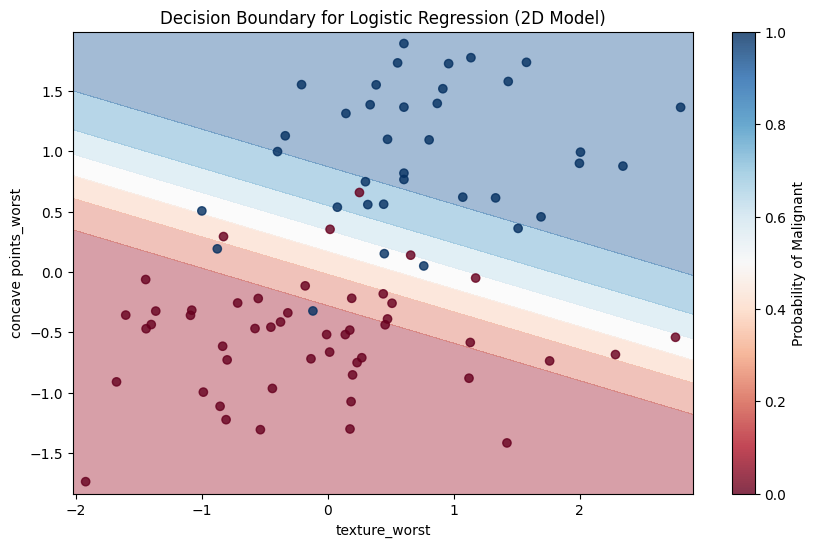

Accuracy on test data: 0.906


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# فرض بر اینه که X_train_scaled_selected، X_test_scaled_selected، y_train، و y_test از قبل تعریف شدن
# استخراج شاخص‌های دو ویژگی اصلی (texture_worst و concave points_worst)
feature_indices = [13, 19]  # 13 برای texture_worst و 19 برای concave points_worst (بر اساس ضرایب قبلی)

# انتخاب داده‌های 2بعدی از دیتای آموزشی و تست
X_train_2d = X_train_scaled_selected[:, feature_indices]
X_test_2d = X_test_scaled_selected[:, feature_indices]
y_train = y_train  # لیبل‌های آموزشی
y_test = y_test    # لیبل‌های تست

# فیت کردن مدل جدید با 2 ویژگی
model_2d = LogisticRegression(max_iter=1000, C=0.83, penalty='l2', class_weight='balanced', random_state=42)
model_2d.fit(X_train_2d, y_train)

# پیش‌بینی روی دیتای تست
y_pred = model_2d.predict(X_test_2d)

# ایجاد شبکه مش برای رسم مرز تصمیم‌گیری
x_min, x_max = X_test_2d[:, 0].min() - 0.1, X_test_2d[:, 0].max() + 0.1
y_min, y_max = X_test_2d[:, 1].min() - 0.1, X_test_2d[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]

# پیش‌بینی روی شبکه مش
Z = model_2d.predict_proba(grid)[:, 1]
Z = Z.reshape(xx.shape)

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, alpha=0.8, cmap=plt.cm.RdBu)
plt.xlabel('texture_worst')
plt.ylabel('concave points_worst')
plt.title('Decision Boundary for Logistic Regression (2D Model)')
plt.colorbar(label='Probability of Malignant')
plt.show()

# نمایش دقت روی دیتای تست (اختیاری)
accuracy = model_2d.score(X_test_2d, y_test)
print(f"Accuracy on test data: {accuracy:.3f}")